In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataset_185_yeast.csv')
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000,1484.000000
mean,0.500121,0.499933,0.500034,0.261186,0.504717,0.007500,0.499885,0.276199
std,0.137299,0.123924,0.086670,0.137098,0.048351,0.075683,0.057797,0.106491
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.410000,0.420000,0.460000,0.170000,0.500000,0.000000,0.480000,0.220000
50%,0.490000,0.490000,0.510000,0.220000,0.500000,0.000000,0.510000,0.220000
75%,0.580000,0.570000,0.550000,0.320000,0.500000,0.000000,0.530000,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,0.730000,1.000000


In [3]:
df.isnull().sum(), df.isna().sum()

(mcg                           0
 gvh                           0
 alm                           0
 mit                           0
 erl                           0
 pox                           0
 vac                           0
 nuc                           0
 class_protein_localization    0
 dtype: int64,
 mcg                           0
 gvh                           0
 alm                           0
 mit                           0
 erl                           0
 pox                           0
 vac                           0
 nuc                           0
 class_protein_localization    0
 dtype: int64)

10

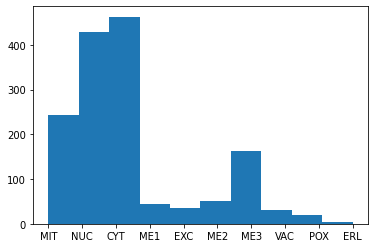

In [4]:
plt.hist(df.class_protein_localization, bins=df.class_protein_localization.nunique())
df.class_protein_localization.nunique()

(array([244., 429., 463., 163.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

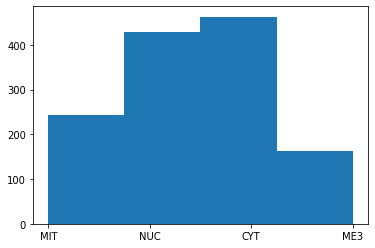

In [5]:
# dropping classes with fewer than 100 entries
classes_to_drop = ["ERL", "POX", "VAC", "ME2", "EXC", "ME1"]
df = df[~df['class_protein_localization'].isin(classes_to_drop)]
plt.hist(df.class_protein_localization, bins=df.class_protein_localization.nunique())

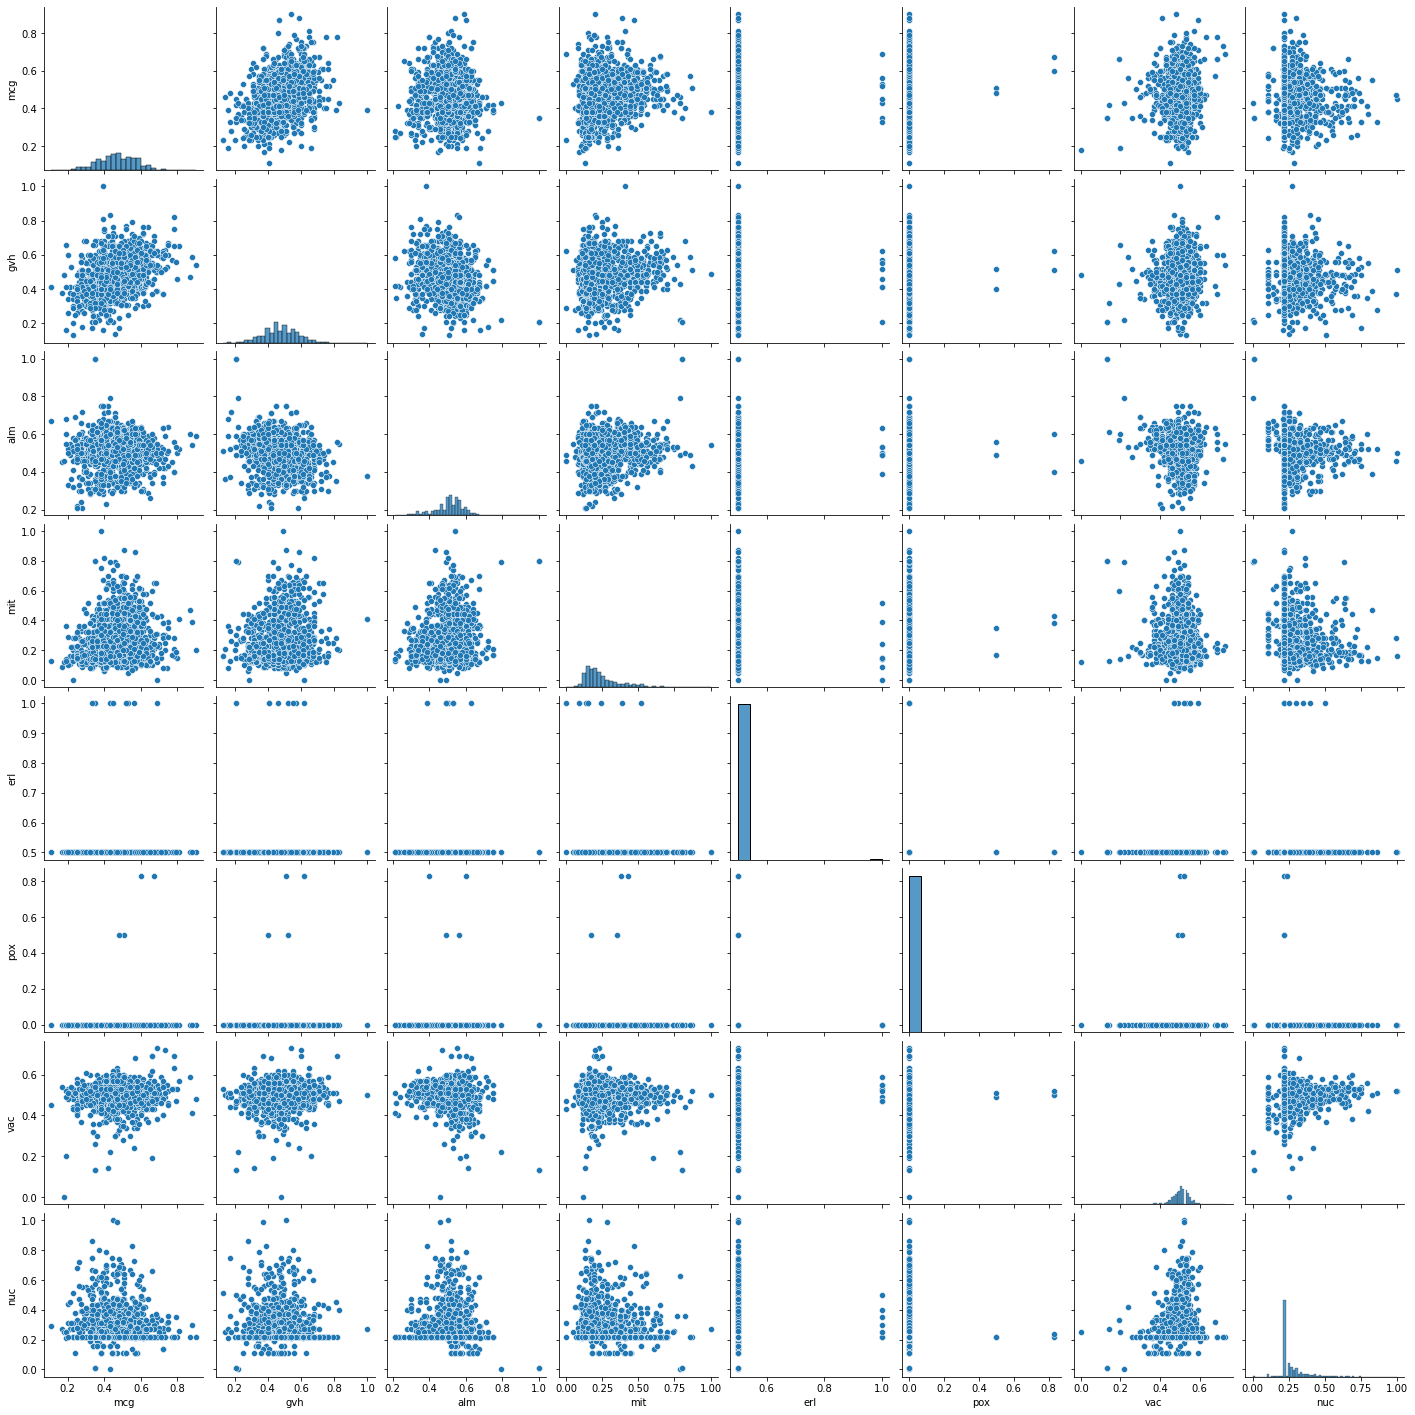

In [6]:
sns.pairplot(df)

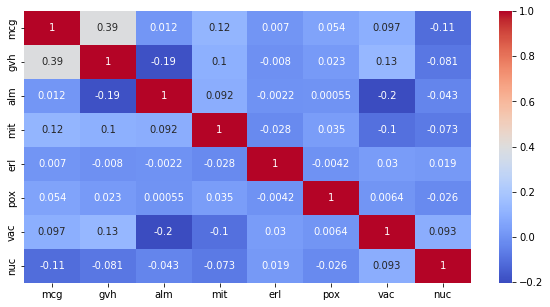

In [7]:
# correlations
plt.figure(figsize = (10,5))
sns.heatmap(df.drop(["class_protein_localization"], axis=1).corr(), annot = True , cmap = 'coolwarm');

In [8]:
# drop pox, almost all values are 0
df = df.drop(["pox"], axis=1)

# drop erl as this offers little information
df = df.drop(["erl"], axis=1)

# shuffle
df = df.sample(frac=1, random_state=1)

(array([244., 429., 463., 163.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

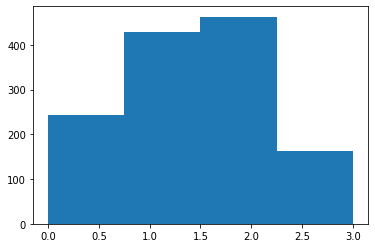

In [9]:
# encode class labels
# MUST start from 0!!
class_labels = {"MIT" : 0, "NUC" : 1, "CYT" : 2, "ME3" : 3}
df.replace(class_labels, inplace = True)
plt.hist(df.class_protein_localization, bins=df.class_protein_localization.nunique())

In [10]:
# split into train/test
split = int(0.7 * len(df))
print(split)

train = df[:split]
test = df[split:]

X_train = train.drop(["class_protein_localization"], axis=1)
X_test = test.drop(["class_protein_localization"], axis=1)

y_train = train.class_protein_localization.values
y_test = test.class_protein_localization.values

# OneHotEncode
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_test

909


array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [11]:
# normalise data
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [12]:
# check null/nan after scaling
X_train.isna().sum(), X_test.isna().sum()

(mcg    0
 gvh    0
 alm    0
 mit    0
 vac    0
 nuc    0
 dtype: int64,
 mcg    0
 gvh    0
 alm    0
 mit    0
 vac    0
 nuc    0
 dtype: int64)

In [13]:
# checking shapes
X_train.shape

(909, 6)

In [14]:
# setting up model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(30, input_dim = X_train.shape[1], activation='relu'))

model.add(Dense(15))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

model.summary()

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 64        
Total params: 739
Trainable params: 739
Non-trainable params: 0
_________________________________________________________________


2021-11-07 20:52:03.795306: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=100, validation_split=0.15, callbacks=[es])
history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=100, validation_split=0.15)

Epoch 1/100


2021-11-07 20:52:04.038927: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


772/772 [==============================] - 1s 915us/step - loss: 1.0930 - accuracy: 0.5065 - val_loss: 0.8998 - val_accuracy: 0.6058
Epoch 2/100
772/772 [==============================] - 1s 789us/step - loss: 0.9138 - accuracy: 0.5881 - val_loss: 0.8550 - val_accuracy: 0.6423
Epoch 3/100
772/772 [==============================] - 1s 797us/step - loss: 0.8762 - accuracy: 0.6010 - val_loss: 0.8720 - val_accuracy: 0.6423
Epoch 4/100
772/772 [==============================] - 1s 777us/step - loss: 0.8524 - accuracy: 0.6166 - val_loss: 0.8985 - val_accuracy: 0.6204
Epoch 5/100
772/772 [==============================] - 1s 787us/step - loss: 0.8462 - accuracy: 0.6205 - val_loss: 0.9200 - val_accuracy: 0.6423
Epoch 6/100
772/772 [==============================] - 1s 786us/step - loss: 0.8515 - accuracy: 0.6114 - val_loss: 0.8964 - val_accuracy: 0.6277
Epoch 7/100
772/772 [==============================] - 1s 791us/step - loss: 0.8334 - accuracy: 0.6373 - val_loss: 0.9628 - val_accuracy: 0.62

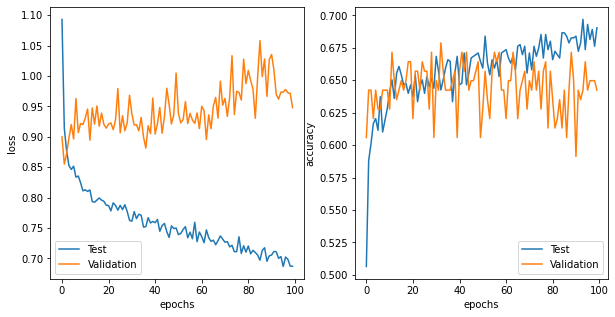

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
_ = axs[0].plot(history.history['loss'], label='Test')
_ = axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('loss')
_ = axs[0].legend()

_ = axs[1].plot(history.history['accuracy'], label='Test')
_ = axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('accuracy')
_ = axs[1].legend()

In [17]:
# TODO predictions and confusion matrix
model.predict(X_test)

array([[5.53288721e-02, 2.92954087e-01, 6.51698768e-01, 1.82376170e-05],
       [2.85900594e-03, 6.99645758e-01, 2.97478199e-01, 1.69797422e-05],
       [4.77224021e-05, 6.43257618e-01, 3.56380314e-01, 3.14418081e-04],
       ...,
       [1.87271968e-01, 2.87234545e-01, 5.06891489e-01, 1.86019670e-02],
       [1.03421554e-01, 3.01261872e-01, 5.95312178e-01, 4.40143367e-06],
       [7.75712309e-03, 2.17163507e-02, 5.83542604e-03, 9.64691043e-01]],
      dtype=float32)